### Statistical Analysis of TRI Release by Industry Sector, 1987-2016

In [1]:
#import libraries
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt

In [2]:
us_dfs = [pd.read_csv('./clean_TRI_Data/US_TRI/TRI_%d_US_CLEAN.csv' % x).drop('Unnamed: 0', axis=1) for x in range(1987,2017)]

/Users/jfd/miniconda3/envs/py27/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
dfdict = {x['YEAR'][0]:x for x in us_dfs}

--------------------------------------

### Outliers in the data

For the fourth class assignment, I looked at the US emissions for a single industry sector, Rubber and Plastics, from the period 1987-2016. One thing that stood out to me was that the extreme outliers (more than three standard deviations from the mean) in those data accounted for a very large portion of the overall releases for the entire industry sector.

Below, I've modified some of the techniques used in the previous assignment so that we can quickly identify information about outliers in a given industry sector for a given year.

In [4]:
def outlierStats(dfdict, year, stdDevs=3, category='Chemicals', printSummary=False):
    thisYear = dfdict[year][dfdict[year].INDUSTRY_SECTOR == category]
    #total number of entries for this year in given category
    totalLen = len(thisYear)
    #split up outliers > stdDevs standard deviations from mean
    outliers = thisYear[np.abs(thisYear.TOTAL_RELEASES-thisYear.TOTAL_RELEASES.mean())>=(stdDevs*thisYear.TOTAL_RELEASES.std())]
    rest = thisYear[np.abs(thisYear.TOTAL_RELEASES-thisYear.TOTAL_RELEASES.mean())<=(stdDevs*thisYear.TOTAL_RELEASES.std())]

    if printSummary:
        print '----------%d Data: %s Industry Sector----------' % (year, category)
    
    numOutliers = len(outliers)
    if numOutliers > 0:
        topOutlier = outliers.sort_values('TOTAL_RELEASES')['FACILITY_NAME'].iloc[0]
        topOutlierRelease = outliers.sort_values('TOTAL_RELEASES')['TOTAL_RELEASES'].iloc[0]
    else:
        topOutlier = 'none'
        topOutlierRelease = 0
    
    if printSummary:
        print 'Outliers represent %%%.4f of total data points' % (100*(numOutliers/float(totalLen)))
        print '%d value(s) > %.3f standard deviations from the mean.' % (numOutliers,stdDevs)
    
    outlierSum = outliers['TOTAL_RELEASES'].sum()
    sansOutlierSum = rest['TOTAL_RELEASES'].sum()

    totalReleases = outlierSum + sansOutlierSum
    if printSummary:
        print 'Outliers accounted for %%%.2f of total release (lbs) in the %s sector' % ((100*outlierSum/float(totalReleases)),category)
        print 'Values within %s s.d. accounted for %%%.2f of total release (lbs) in the %s sector' % (stdDevs,(100*sansOutlierSum/float(totalReleases)),category)
        
    return pd.Series({
        'YEAR':year,
        'INDUSTRY_SECTOR':category,
        'NUM_RECORDS':totalLen,
        'NUM_OUTLIERS':numOutliers,
        'TOP_OUTLIER':topOutlier,
        'TOP_OUTLIER_RELEASE':topOutlierRelease,
        'OUTLIER_LIMIT':stdDevs,
        'TOTAL_RELEASES':totalReleases,
        'TOTAL_OUTLIER_RELEASES':outlierSum,
    })

In [5]:
#looking at Beverages for example
outlierStats(dfdict, 2005,3,'Beverages',True)

----------2005 Data: Beverages Industry Sector----------
Outliers represent %0.6944 of total data points
1 value(s) > 3.000 standard deviations from the mean.
Outliers accounted for %54.11 of total release (lbs) in the Beverages sector
Values within 3 s.d. accounted for %45.89 of total release (lbs) in the Beverages sector


INDUSTRY_SECTOR                    Beverages
NUM_OUTLIERS                               1
NUM_RECORDS                              144
OUTLIER_LIMIT                              3
TOP_OUTLIER               ANHEUSER-BUSCH LLC
TOP_OUTLIER_RELEASE              2.70484e+06
TOTAL_OUTLIER_RELEASES           2.70484e+06
TOTAL_RELEASES                   4.99915e+06
YEAR                                    2005
dtype: object

In [6]:
categories = list(set(dfdict[2016].INDUSTRY_SECTOR.values)) 
outlier_df_array = [outlierStats(dfdict,x,3,y) for x in range(1987,2017) for y in categories]
outlier_dict = {x:filter(lambda y : y.YEAR == x, outlier_df_array) for x in range(1987,2017)}

In [7]:
#array of outlier stats Series for given year 
outlier_dict[1987]

[INDUSTRY_SECTOR               Publishing
 NUM_OUTLIERS                           1
 NUM_RECORDS                           41
 OUTLIER_LIMIT                          3
 TOP_OUTLIER               AMOS PRESS INC
 TOP_OUTLIER_RELEASE               302400
 TOTAL_OUTLIER_RELEASES            302400
 TOTAL_RELEASES                    855374
 YEAR                                1987
 dtype: object, INDUSTRY_SECTOR                       Electrical Equipment
 NUM_OUTLIERS                                            23
 NUM_RECORDS                                           2378
 OUTLIER_LIMIT                                            3
 TOP_OUTLIER               WHIRLPOOL CORP MARION OPERATIONS
 TOP_OUTLIER_RELEASE                                 321750
 TOTAL_OUTLIER_RELEASES                         1.61587e+07
 TOTAL_RELEASES                                 5.98734e+07
 YEAR                                                  1987
 dtype: object, INDUSTRY_SECTOR           Plastics and Rubber
 NUM_

In [8]:
def plotOutlierInfo(year,attribute):
    this_df = pd.DataFrame(outlier_dict[year],index=categories).sort_values(attribute,ascending=False)
    this_df[attribute].plot(kind='bar',title='%d %s By Industry Sector' % (year,attribute))
    plt.show()

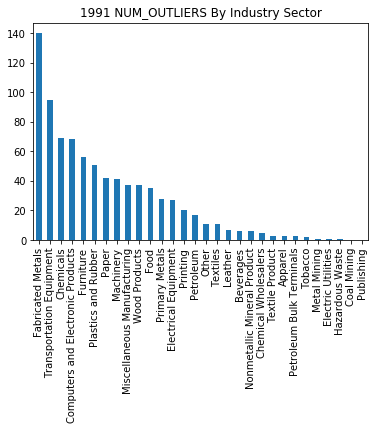

In [9]:
plotOutlierInfo(1991,'NUM_OUTLIERS')

In [30]:
def summarizeAndPlot(startYear, endYear, dfdict, category='Chemicals'):
    def basicStatsSummary(startYear, endYear, dfdict, category='Chemicals'):
        year_df_array = []

        for year in range(startYear, endYear+1):
            year_df_array.append({'year': year, 'df': dfdict[year][dfdict[year].INDUSTRY_SECTOR == category].TOTAL_RELEASES})

        for i in range(len(year_df_array)):
            year = year_df_array[i]['year']
            year_df_releases = year_df_array[i]['df']
            year_df_array[i]['total'] = year_df_releases.sum()
            year_df_array[i]['mean'] = year_df_releases.mean()
            year_df_array[i]['median'] = year_df_releases.median()
        
        return year_df_array

    
    def plotSummaryAttr(col):
        summary[col].plot(kind='kde', title=('Distribution of %s %s-%s, %s' % (col,startYear,endYear,category)), xlim=(summary[col].min(),summary[col].max()))
        ymax = max(plt.gca().get_ylim())
        plt.vlines(summary[col].mean(),
                   ymin=0, 
                   ymax=ymax,
                   linewidth=2.0)

        plt.vlines(summary[col].median(),
                   ymin=0, 
                   ymax=ymax,
                   linewidth=2.0,
                   color='red')

        plt.gca().set_ylim(0)
        plt.show()
        
    year_df_objs = basicStatsSummary(startYear, endYear, dfdict, category)
    
    yearlist = [year_df_objs[i]['year'] for i in range(len(year_df_objs))]
    totals = [year_df_objs[i]['total'] for i in range(len(year_df_objs))] 
    means = [year_df_objs[i]['mean'] for i in range(len(year_df_objs))] 
    medians = [year_df_objs[i]['median'] for i in range(len(year_df_objs))]

    summary = pd.DataFrame({
        'Year': yearlist,
        'Total': totals,
        'Mean': means,
        'Median': medians
    })
    
    yearRange = [x for x in range(1987,2017)]
    
    summary['Total'].plot(kind='bar', title='Total Releases %s-%s, %s' % (startYear,endYear,category))
    plt.xticks(np.arange(30),yearRange)
    plt.show()
    plotSummaryAttr('Total')
    summary['Total'].plot(kind='box', title='Total Releases %s-%s, %s' % (startYear,endYear,category))
    plt.show()
    
    summary['Mean'].plot(kind='bar', title='Mean Value %s-%s, %s' % (startYear,endYear,category))
    plt.xticks(np.arange(30),yearRange)
    plt.show()
    plotSummaryAttr('Mean')
    summary['Mean'].plot(kind='box', title='Mean Value %s-%s, %s' % (startYear,endYear,category))
    plt.show()
    
    summary['Median'].plot(kind='bar', title='Median Value %s-%s, %s' % (startYear,endYear,category))
    plt.xticks(np.arange(30),yearRange)
    plt.show()
    plotSummaryAttr('Median')
    summary['Median'].plot(kind='box', title='Median Value %s-%s, %s' % (startYear,endYear,category))
    plt.show()
    

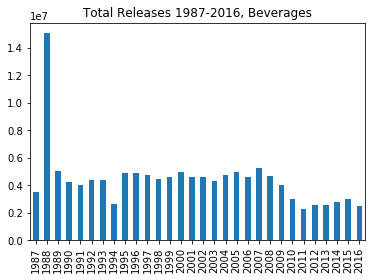

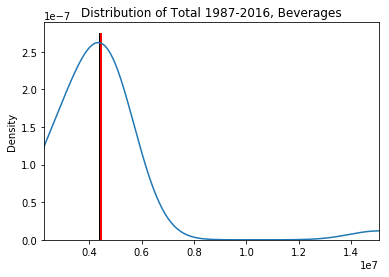

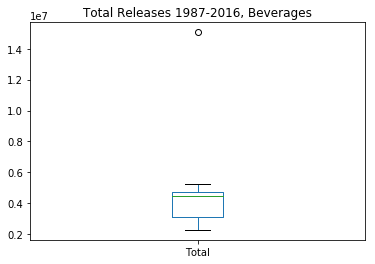

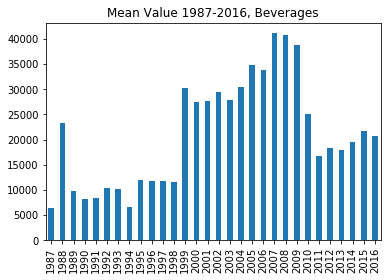

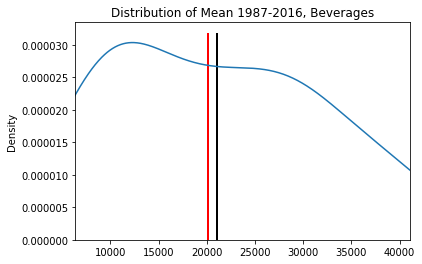

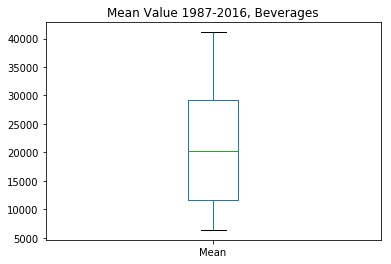

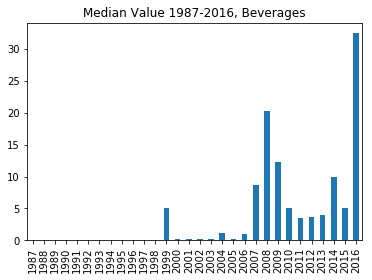

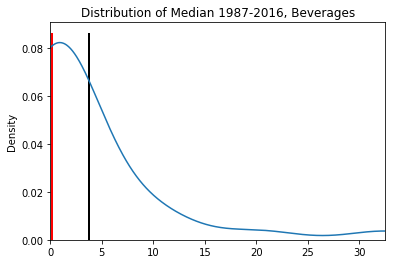

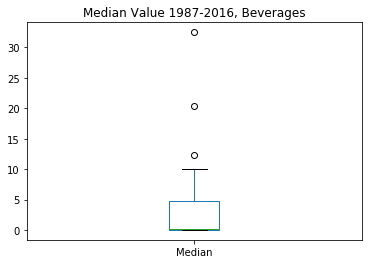

In [31]:
summarizeAndPlot(1987,2016,dfdict,'Beverages')